# DoorDash Delivery Duration Prediction
The goal is to predict reliable estimate for total delivery time (`actual_delivery_time` - `created_at`)

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [38]:
raw_data = pd.read_csv('../../datasets/doordash_historical_data.csv')
data = raw_data.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

## Visualizing Missing Data
We shall plot a missingness matrix to visualize missing data

<AxesSubplot:>

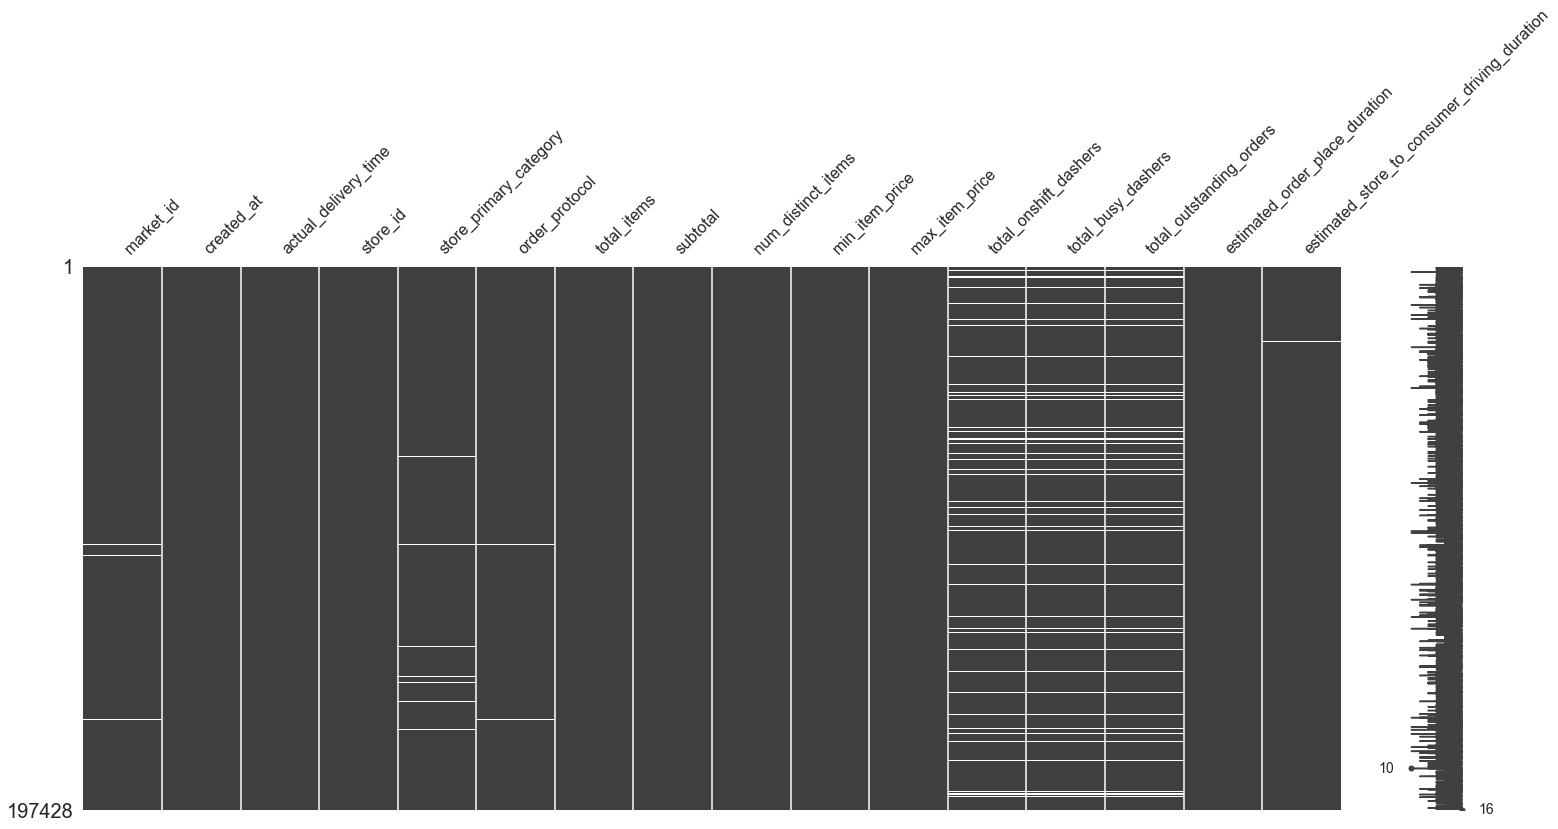

In [39]:
import missingno as msno

msno.matrix(data)

Since our data set is fairly large, we can consider deleting rows with missing values if it is unlikely to cause bias in our sample.
In this data set, we shall drop observations with missing `market_id`,`store_primary_category` or `order_protocol`.

In [41]:
data = data.dropna(subset=['market_id','store_primary_category', 'order_protocol'])

<AxesSubplot:>

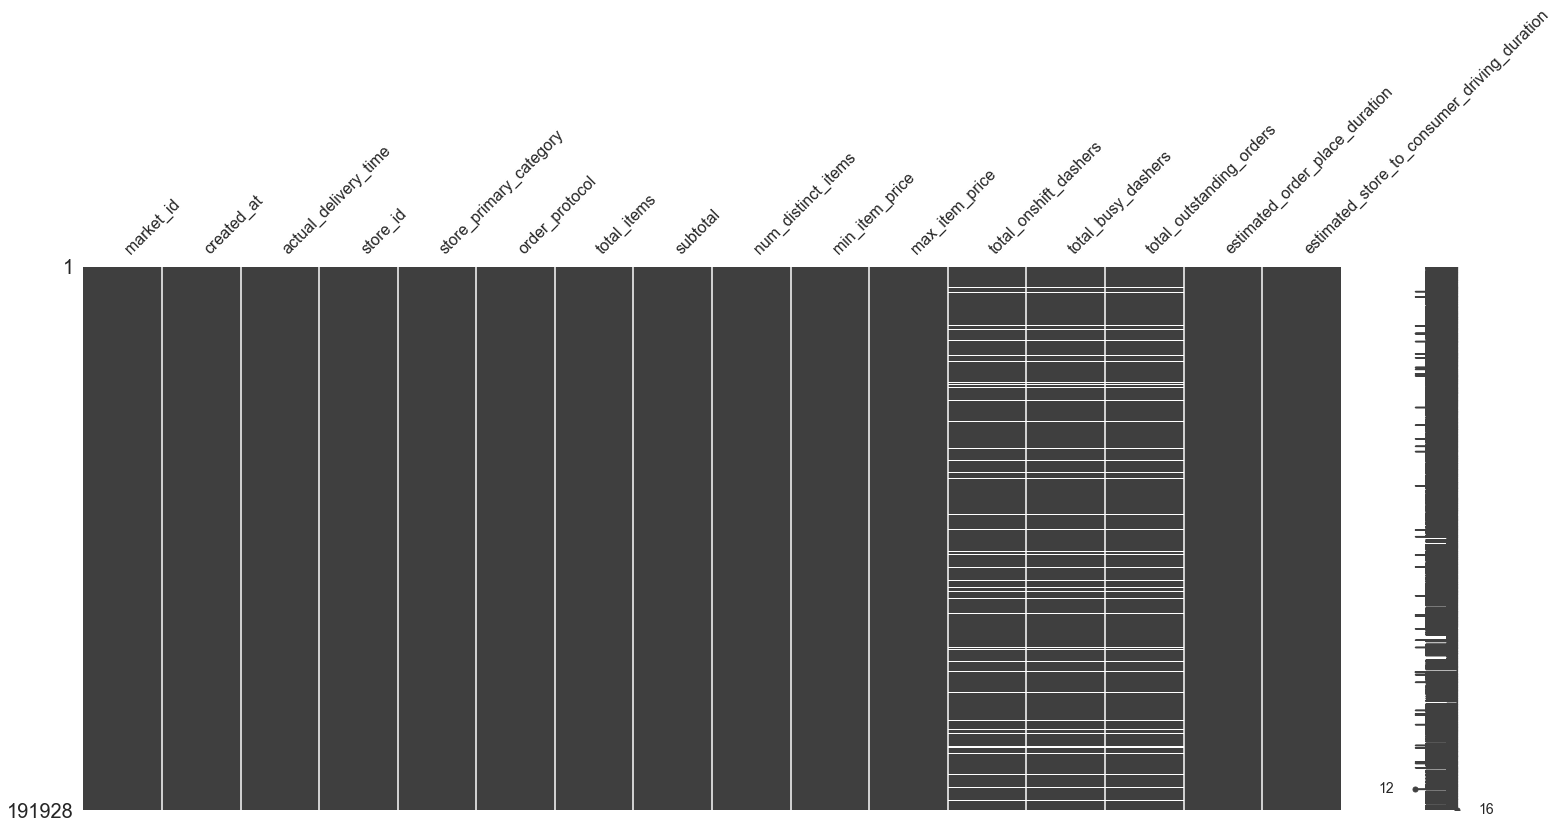

In [42]:
msno.matrix(data)

We now notice that quite a number values for `total_onshift_dashers` `total_busy_dashers` `total_outstanding_orders` are missing.
It is likely that certain stores do not track the number of dashers and outstanding orders they have.
In this case, we can choose to impute their missing values with their respective means through scikit-learn's simple imputer.

```
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
imputer = imputer.fit(data[['total_onshift_dashers','total_busy_dashers', 'total_outstanding_orders']])
data[['total_onshift_dashers','total_busy_dashers', 'total_outstanding_orders']] = imputer.transform(data[['total_onshift_dashers','total_busy_dashers', 'total_outstanding_orders']])
```

Alternatively, we can choose to impute their means through the respective `market_id` groups, which may be more representative.

In [43]:
data.groupby('market_id').mean()['total_onshift_dashers']

market_id
1.0    24.239901
2.0    62.516708
3.0    18.922301
4.0    60.811221
5.0    23.852882
6.0    45.190625
Name: total_onshift_dashers, dtype: float64

In [44]:
market_features = ['total_onshift_dashers','total_busy_dashers', 'total_outstanding_orders']
for market_feature in market_features:
    data[market_feature] = data.groupby('market_id')[market_feature].transform(lambda x: x.fillna(x.mean()))

<AxesSubplot:>

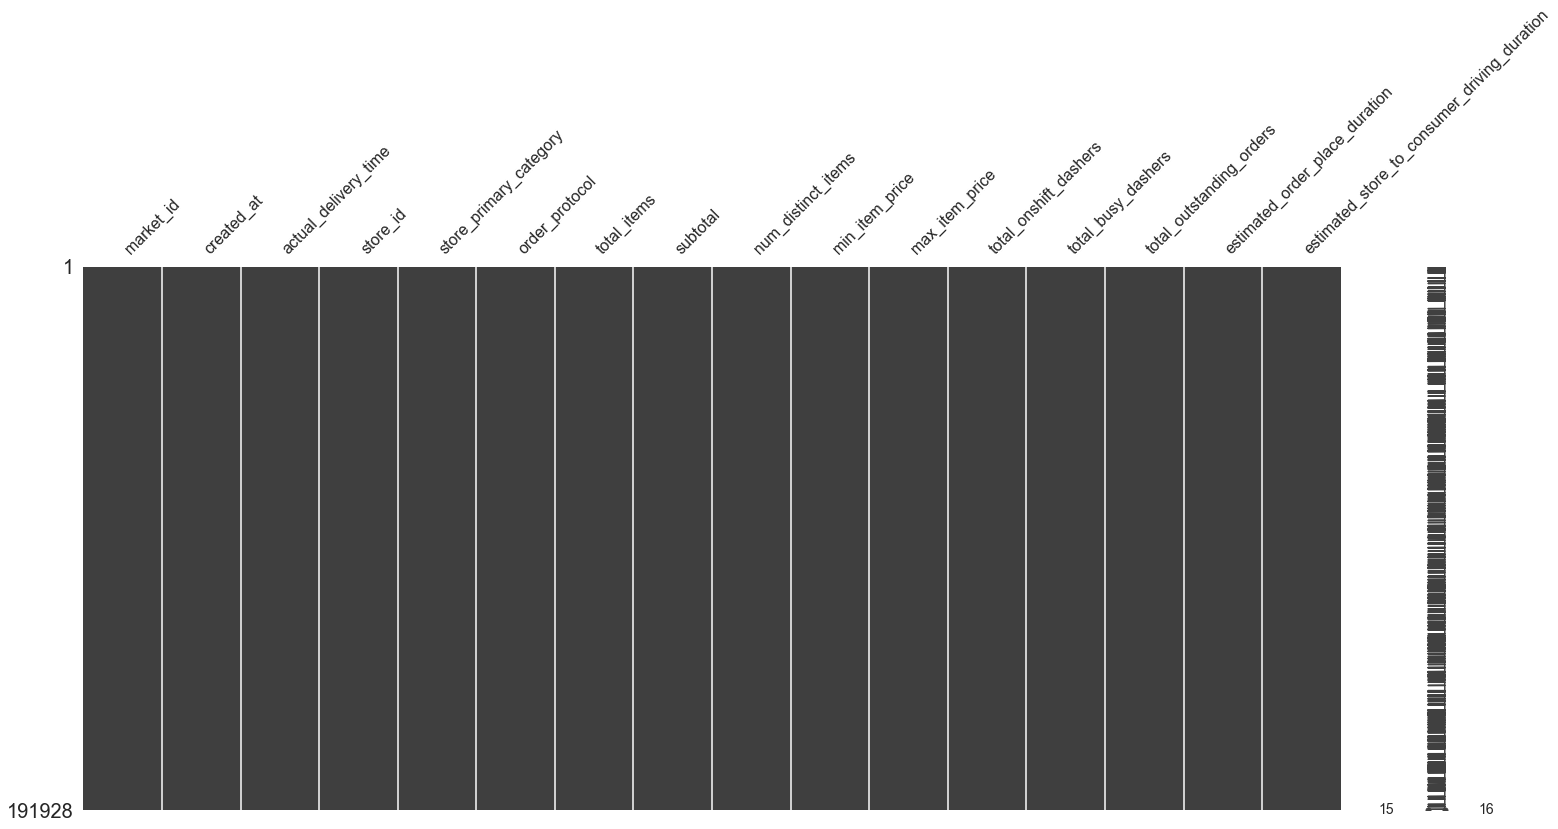

In [45]:
msno.matrix(data)

In [46]:
data.describe()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
count,191928.000000,191928.000000,191928.000000,191928.000000,191928.000000,191928.000000,191928.000000,191928.000000,191928.000000,191928.000000,191928.000000,191928.000000,191414.000000
mean,2.971760,3540.012635,2.897904,3.193505,2679.683892,2.668152,685.699570,1158.260660,44.723387,41.678503,57.960058,307.474829,545.507816
std,1.523217,2051.350641,1.501557,2.668694,1822.902612,1.628802,520.427242,557.204799,33.193794,30.913475,50.658566,89.579362,219.418717
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000
25%,2.000000,1695.000000,1.000000,2.000000,1400.000000,1.000000,299.000000,799.000000,18.922301,17.000000,19.000000,251.000000,382.000000
50%,3.000000,3600.000000,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,40.000000,38.000000,46.000000,251.000000,544.000000
75%,4.000000,5302.000000,4.000000,4.000000,3393.000000,3.000000,949.000000,1395.000000,62.000000,60.000000,80.000000,446.000000,702.000000
max,6.000000,6987.000000,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000


Now that missing values in our data have been cleaned, it is time to introduce new features into our data.
* `actual_total_delivery_duration` is our target variable, and is equal to `actual_delivery_time` - `created_at`
* `busy_dashers_ratio` is possibly a stronger predictor for our target variable, given that `total_busy_dashers` and `total_onshift_dashers` may be misleading
* `estimated_non_prep_duration` combines both `estimated_order_place_duration` and `estimated_store_to_consumer_driving_duration` predictions from other models

`actual_total_delivery_duration`

In [47]:
import datetime
data['created_at'] = pd.to_datetime(data['created_at'])
data['actual_delivery_time'] = pd.to_datetime(data['actual_delivery_time'])
data['actual_total_delivery_duration'] = (data['actual_delivery_time'] - data['created_at']).dt.total_seconds()

In [48]:
data['actual_total_delivery_duration'].describe()

count    1.919210e+05
mean     2.908290e+03
std      1.950222e+04
min      1.010000e+02
25%      2.104000e+03
50%      2.659000e+03
75%      3.380000e+03
max      8.516859e+06
Name: actual_total_delivery_duration, dtype: float64

`busy_dashers_ratio`

In [49]:
data['busy_dashers_ratio'] = data['total_busy_dashers'] / data['total_onshift_dashers']

* We note that when we are dealing with ratios, there may be division by zero errors.

In [50]:
data['busy_dashers_ratio'].describe()

count    1.884170e+05
mean              NaN
std               NaN
min              -inf
25%      8.444444e-01
50%      9.473684e-01
75%      1.000000e+00
max               inf
Name: busy_dashers_ratio, dtype: float64

In [51]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

In [52]:
data['busy_dashers_ratio'].describe()

count    187866.000000
mean          0.948937
std           0.388523
min         -13.000000
25%           0.844444
50%           0.947368
75%           1.000000
max          31.000000
Name: busy_dashers_ratio, dtype: float64

`estimated_non_prep_duration`

In [55]:
data['estimated_non_prep_duration'] = data['estimated_order_place_duration'] + data['estimated_store_to_consumer_driving_duration']

In [56]:
data['estimated_non_prep_duration'].describe()

count    187866.000000
mean        852.563732
std         234.732455
min         153.000000
25%         682.000000
50%         849.000000
75%        1015.000000
max        3222.000000
Name: estimated_non_prep_duration, dtype: float64

Now, it is necessary to convert our categorical variables into dummies to train our model.

We note that in order to reduce multicollinearity in our dummy variables, 1 dummy should be dropped for each categorical feature, which is to be used as the baseline category.

For store features, we have: 
* `market_id` 
* `store_primary_category` 
* `order_protocol`

In [57]:
# create dummies for market_id
market_id_dummies = pd.get_dummies(data.market_id, drop_first=True)
market_id_dummies = market_id_dummies.add_prefix('market_id_')
market_id_dummies.head()


,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0
0,0,0,0,0,0
1,1,0,0,0,0
8,1,0,0,0,0
14,0,0,0,0,0
15,0,0,0,0,0


In [58]:
# create dummies for store primary category
store_primary_category_dummies = pd.get_dummies(data.store_primary_category)
store_primary_category_dummies = store_primary_category_dummies.add_prefix('category_')

In [59]:
data['store_primary_category'].mode()

0    american
Name: store_primary_category, dtype: object

In [60]:
store_primary_category_dummies = store_primary_category_dummies.drop('category_american', axis=1)

In [61]:
# create dummies for order protocol
order_protocol_dummies = pd.get_dummies(data.order_protocol, drop_first=True)
order_protocol_dummies = order_protocol_dummies.add_prefix('order_protocol_')
order_protocol_dummies.head()

,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0
0,0,0,0,0,0,0
1,1,0,0,0,0,0
8,0,1,0,0,0,0
14,0,0,0,0,0,0
15,0,0,0,0,0,0


Respectively for `market_id_dummies`, `store_primary_category_dummies`, `order_protocol_dummies`, their respective baseline categories are:
* `market_id_1.0`
* `category_american`
* `order_protocol_1.0`

Now that we have created our dummy variables, we can drop the unnecessary columns.

In [62]:
data.columns.values

array(['market_id', 'created_at', 'actual_delivery_time', 'store_id',
       'store_primary_category', 'order_protocol', 'total_items',
       'subtotal', 'num_distinct_items', 'min_item_price',
       'max_item_price', 'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration',
       'actual_total_delivery_duration', 'busy_dashers_ratio',
       'estimated_non_prep_duration'], dtype=object)

In [63]:
dropped_cols = ['created_at','actual_delivery_time', 'market_id', 'store_id', 'store_primary_category', 'order_protocol',  
                'total_onshift_dashers', 'total_busy_dashers', 'estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration']
train_df = data.drop(columns=dropped_cols)

* `store_id` is also removed to simplify our model.

In [64]:
train_df = pd.concat([train_df, market_id_dummies, store_primary_category_dummies, order_protocol_dummies], axis=1)
train_df = train_df.astype("float32") # good practice to set dataframe.astype to prevent errors from occurring
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,actual_total_delivery_duration,busy_dashers_ratio,estimated_non_prep_duration,market_id_2.0,...,category_turkish,category_vegan,category_vegetarian,category_vietnamese,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0
0,4.0,3441.0,4.0,557.0,1239.0,21.0,3779.0,0.424242,1307.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,4024.0,2.000000,1136.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,4.0,4771.0,3.0,820.0,1604.0,18.0,1586.0,0.750000,735.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
14,1.0,1525.0,1.0,1525.0,1525.0,8.0,2273.0,1.200000,1241.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,2.0,3620.0,2.0,1425.0,2195.0,7.0,2988.0,1.000000,651.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
train_df.shape

(187866, 93)

<AxesSubplot:>

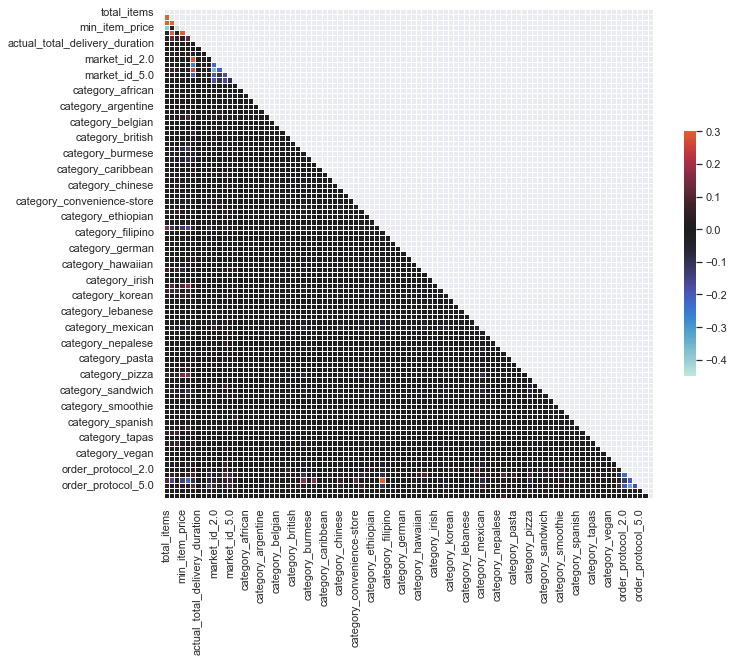

In [66]:
# it could take some time to run this cell since we are calculating correlation matrix in a dimension of (100x100)
# to have a better visualization, we will take only one triangle 
# because other triangle is only its symmetry (i.e a x b and b x a)

# Generate a mask for the upper triangle
corr = train_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.color_palette("icefire", as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

The following are functions written to obtain the top absolute correlated features.

In [67]:
def get_redundant_pairs(df):
    """Get diagonal and lower triangular pairs of correlation matrix"""
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    """Sort correlations in the descending order and return n highest results"""
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [68]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_items               num_distinct_items    0.760825
subtotal                  num_distinct_items    0.682125
total_items               subtotal              0.555243
min_item_price            max_item_price        0.542474
category_fast             order_protocol_4.0    0.509031
subtotal                  max_item_price        0.506313
num_distinct_items        min_item_price        0.450190
total_items               min_item_price        0.393214
market_id_2.0             market_id_4.0         0.362166
order_protocol_3.0        order_protocol_5.0    0.335017
total_outstanding_orders  market_id_2.0         0.286294
                          market_id_3.0         0.271106
                          market_id_4.0         0.269991
order_protocol_2.0        order_protocol_3.0    0.230370
market_id_2.0             market_id_3.0         0.226841
max_item_price            order_protocol_4.0    0.220218
total_outstanding_orders  market_id_5.0         0.207051
marke

It seems that order features are highly correlated with each other.

We shall create 2 new features:
* `average_subtotal_of_total_items` = `subtotal` / `total_items`
* `max_min_item_price_difference` = `max_item_price` - `min_item_price`


In [69]:
train_df['average_subtotal_of_total_items'] = train_df['subtotal']/train_df['total_items']

In [70]:
train_df['average_subtotal_of_total_items'].describe()

count    187866.000000
mean        976.636719
std         515.863159
min           0.000000
25%         649.000000
50%         895.000000
75%        1195.000000
max       14700.000000
Name: average_subtotal_of_total_items, dtype: float64

It might be worth noting that subtotals of 0 could be errors. We shall drop them.

In [79]:
(train_df['average_subtotal_of_total_items']==0).sum()

169

In [81]:
train_df = train_df.drop(train_df[train_df['average_subtotal_of_total_items']== 0].index)


In [71]:
train_df['max_min_item_price_difference'] = train_df['max_item_price'] - train_df['min_item_price']

In [72]:
train_df['max_min_item_price_difference'].describe()

count    187866.000000
mean        473.640411
std         516.379150
min        -198.000000
25%           0.000000
50%         370.000000
75%         750.000000
max        8400.000000
Name: max_min_item_price_difference, dtype: float64

It might be worth noting that prices differences < 0 could be errors. We shall drop them.

In [78]:
(train_df['max_min_item_price_difference']<0).sum()

776

In [82]:
train_df = train_df.drop(train_df[train_df['max_min_item_price_difference'] < 0].index)

In [75]:
cols_to_drop = ['total_items','subtotal','num_distinct_items','min_item_price','max_item_price']
train_df = train_df.drop(columns=cols_to_drop)
train_df.shape


(187866, 90)

In [76]:
dropped_cols.extend(cols_to_drop)
dropped_cols

['created_at',
 'actual_delivery_time',
 'market_id',
 'store_id',
 'store_primary_category',
 'order_protocol',
 'total_onshift_dashers',
 'total_busy_dashers',
 'estimated_order_place_duration',
 'estimated_store_to_consumer_driving_duration',
 'total_items',
 'subtotal',
 'num_distinct_items',
 'min_item_price',
 'max_item_price']

In [85]:
train_df.shape

(186921, 90)

In [86]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
category_fast             order_protocol_4.0                 0.508724
market_id_2.0             market_id_4.0                      0.362316
order_protocol_3.0        order_protocol_5.0                 0.335170
total_outstanding_orders  market_id_2.0                      0.286394
                          market_id_3.0                      0.271130
                          market_id_4.0                      0.269797
order_protocol_2.0        order_protocol_3.0                 0.230406
market_id_2.0             market_id_3.0                      0.226869
category_pizza            average_subtotal_of_total_items    0.225995
order_protocol_4.0        average_subtotal_of_total_items    0.212384
total_outstanding_orders  market_id_5.0                      0.207250
market_id_3.0             market_id_4.0                      0.205345
order_protocol_2.0        order_protocol_5.0                 0.204687
order_protocol_3.0        order_protocol_4.0                 0.2

### Multicollinearity Check

In [87]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

In [88]:
def compute_vif(features):
    """Compute VIF score using variance_inflation_factor() function"""
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    vif_data["VIF"] = [VIF(train_df[features].values, i) for i in range(len(features))]
    return vif_data.sort_values(by=['VIF']).reset_index(drop=True)

In [89]:
# apply VIF computation to all columns
features = train_df.drop(columns=["actual_total_delivery_duration"]).columns.to_list()
vif_data = compute_vif(features)
vif_data

,feature,VIF
0,category_alcohol-plus-food,1.000116
1,category_chocolate,1.000159
2,category_belgian,1.000184
3,category_indonesian,1.000276
4,category_lebanese,1.000449
...,...,...
84,market_id_2.0,3.034370
85,total_outstanding_orders,3.413772
86,average_subtotal_of_total_items,5.005207
87,busy_dashers_ratio,6.140343


As a rule of thumb, VIF that exceeds 5 or 10 indicates a problematic amount of multicollinearity.

We shall remove `estimated_non_prep_duration` and use `estimated_store_to_consumer_driving_duration` instead

In [102]:
train_df = train_df.drop(columns='estimated_non_prep_duration')

In [103]:
train_df['estimated_store_to_consumer_driving_duration'] = data['estimated_store_to_consumer_driving_duration']

In [109]:
train_df.shape

(186921, 90)

In [100]:
dropped_cols.append('estimated_non_prep_duration')
dropped_cols.remove('estimated_store_to_consumer_driving_duration')

In [101]:
dropped_cols

['created_at',
 'actual_delivery_time',
 'market_id',
 'store_id',
 'store_primary_category',
 'order_protocol',
 'total_onshift_dashers',
 'total_busy_dashers',
 'estimated_order_place_duration',
 'total_items',
 'subtotal',
 'num_distinct_items',
 'min_item_price',
 'max_item_price',
 'estimated_non_prep_duration']

In [110]:
vif_data = compute_vif(train_df.columns.to_list())
vif_data

,feature,VIF
0,category_alcohol-plus-food,1.000111
1,category_chocolate,1.000153
2,category_belgian,1.000168
3,category_indonesian,1.000254
4,category_lebanese,1.000363
...,...,...
85,market_id_2.0,2.992177
86,total_outstanding_orders,3.410140
87,average_subtotal_of_total_items,4.707814
88,busy_dashers_ratio,5.777967


Our VIF scores are now much lower. We shall now proceed to the modeling step.

In [117]:
selected_features = train_df.columns.to_list()
selected_features.remove('actual_total_delivery_duration')

### Feature Selection

In [120]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X = train_df[selected_features]
y = train_df["actual_total_delivery_duration"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

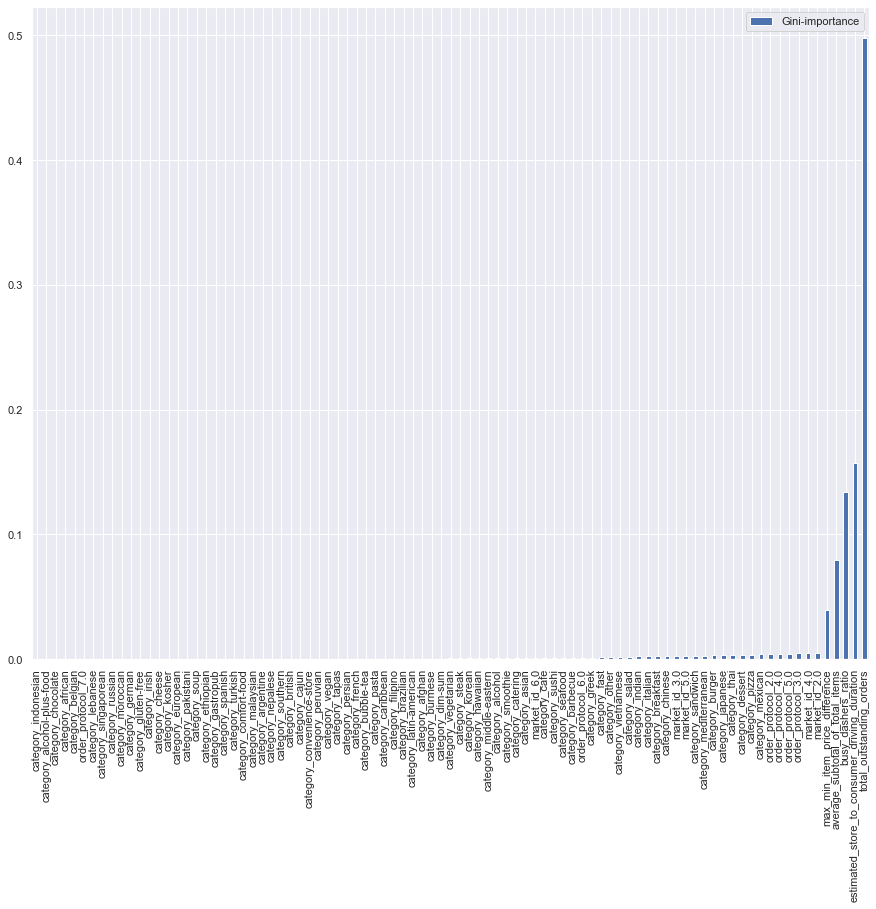

In [121]:
feature_names = [f"feature {i}" for i in range((X.shape[1]))]
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, forest.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90, figsize=(15,12))
plt.show()

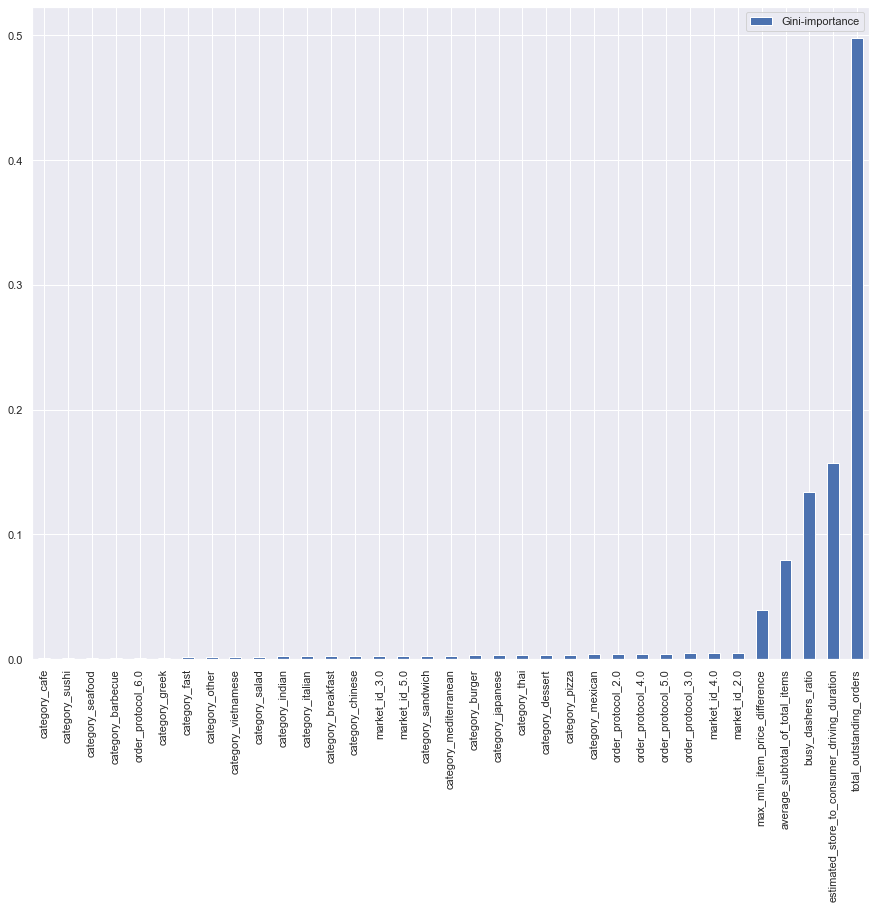

In [122]:
# check the most important ones
importances.sort_values(by='Gini-importance')[-35:].plot(kind='bar', rot=90, figsize=(15,12))
plt.show()

In [123]:
# we can obtain the column names as next
importances.sort_values(by='Gini-importance')[-35:].index.tolist()

['category_cafe',
 'category_sushi',
 'category_seafood',
 'category_barbecue',
 'order_protocol_6.0',
 'category_greek',
 'category_fast',
 'category_other',
 'category_vietnamese',
 'category_salad',
 'category_indian',
 'category_italian',
 'category_breakfast',
 'category_chinese',
 'market_id_3.0',
 'market_id_5.0',
 'category_sandwich',
 'category_mediterranean',
 'category_burger',
 'category_japanese',
 'category_thai',
 'category_dessert',
 'category_pizza',
 'category_mexican',
 'order_protocol_2.0',
 'order_protocol_4.0',
 'order_protocol_5.0',
 'order_protocol_3.0',
 'market_id_4.0',
 'market_id_2.0',
 'max_min_item_price_difference',
 'average_subtotal_of_total_items',
 'busy_dashers_ratio',
 'estimated_store_to_consumer_driving_duration',
 'total_outstanding_orders']

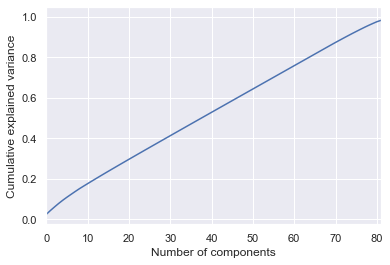

In [124]:
# apply PCA to see feature contributions
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_Train=X_train.values
X_Train=np.asarray(X_Train)

# Finding normalised array of X_Train
X_std=StandardScaler().fit_transform(X_Train)
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,81,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

### Scale the Data

In [125]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def scale(scaler, X, y):
    """Apply the selected scaler to features and target variables"""
    X_scaler = scaler
    X_scaler.fit(X=X, y=y)
    X_scaled = X_scaler.transform(X)
    y_scaler = scaler
    y_scaler.fit(y.values.reshape(-1, 1))
    y_scaled = y_scaler.transform(y.values.reshape(-1, 1))
    
    return X_scaled, y_scaled, X_scaler, y_scaler

In [126]:
# example to show how to use it
X_scaled, y_scaled, X_scaler, y_scaler = scale(MinMaxScaler(), X, y)

In [127]:
# train-test split after scaling
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42)

### Inverse Transform for Metric Comparison

In [128]:
from sklearn.metrics import mean_squared_error

def rmse_with_inv_transform(scaler, y_test, y_pred_scaled, model_name):
    """Convert the scaled error to actual error"""
    y_predict = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    # return RMSE with squared False     
    rmse_error = mean_squared_error(y_test, y_predict[:,0], squared=False)
    print("Error = "'{}'.format(rmse_error)+" in " + model_name)
    
    return rmse_error, y_predict

### Classical Machine Learning

In [129]:
# create a generic function which can work with multiple machine learning models
def make_regression(X_train, y_train, X_test, y_test, model, model_name, verbose=True):
    """Apply selected regression model to data and measure error"""
    model.fit(X_train,y_train)
    y_predict=model.predict(X_train)
    train_error = mean_squared_error(y_train, y_predict, squared=False)
    y_predict=model.predict(X_test)
    test_error = mean_squared_error(y_test, y_predict, squared=False)
    if verbose:
        print("Train error = "'{}'.format(train_error)+" in " + model_name)
        print("Test error = "'{}'.format(test_error)+" in " + model_name)
    trained_model = model
    
    return trained_model, y_predict, train_error, test_error

In [130]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn import svm
from sklearn import neighbors
from sklearn import linear_model

pred_dict = {
    "regression_model": [],
    "feature_set": [],
    "scaler_name": [],
    "RMSE": [],
}


regression_models = {
    "Ridge" : linear_model.Ridge(),
    "DecisionTree" : tree.DecisionTreeRegressor(max_depth=6),
    "RandomForest" : RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "LGBM": LGBMRegressor(),
    "MLP":  MLPRegressor(),
}

feature_sets = {
    "full dataset": X.columns.to_list(),
    "selected_features_40": importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
    "selected_features_20": importances.sort_values(by='Gini-importance')[-20:].index.tolist(),
    "selected_features_10": importances.sort_values(by='Gini-importance')[-10:].index.tolist(), 

    
}

scalers = {
    "Standard scaler": StandardScaler(),
    "MinMax scaler": MinMaxScaler(),
    "NotScale": None,
}

# examine the error for each combination
for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():   
            if scaler_name == "NotScale":
                X = train_df[feature_set]
                y = train_df["actual_total_delivery_duration"]
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                make_regression(X_train, y_train, X_test, y_test, regression_models[model_name], model_name, verbose=True)
            
            else:
                
                X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X[feature_set], y)
                X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
                    X_scaled, y_scaled, test_size=0.2, random_state=42)
                _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=False)
                rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)

            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)

-----scaled with Standard scaler-------- included columns are full dataset

Error = 2041.4311958659393 in Ridge
Error = 2027.9820169071347 in DecisionTree
Error = 7987.839187055332 in RandomForest
Error = 2108.837646484375 in XGBoost
Error = 5259.301132881661 in LGBM
Error = 5975.923180623314 in MLP
-----scaled with MinMax scaler-------- included columns are full dataset

Error = 2041.264925642708 in Ridge
Error = 2027.982016995619 in DecisionTree
Error = 9496.94809786277 in RandomForest
Error = 12087.427734375 in XGBoost
Error = 5239.666613669172 in LGBM
Error = 8690.702945981999 in MLP
-----scaled with NotScale-------- included columns are full dataset

Train error = 22039.510256567024 in Ridge
Test error = 2041.4156801834993 in Ridge
Train error = 1077.8700637629074 in DecisionTree
Test error = 2027.9820169554512 in DecisionTree
Train error = 8585.22673960525 in RandomForest
Test error = 6119.1303578814395 in RandomForest
Train error = 1036.578857421875 in XGBoost
Test error = 2040.

In [259]:
pred_df = pd.DataFrame(pred_dict)

In [260]:
pred_df

,regression_model,feature_set,scaler_name,RMSE
0,Ridge,full dataset,Standard scaler,1131.218628
1,DecisionTree,full dataset,Standard scaler,1105.312934
2,RandomForest,full dataset,Standard scaler,8284.241014
3,XGBoost,full dataset,Standard scaler,1118.983765
4,LGBM,full dataset,Standard scaler,4425.089139
...,...,...,...,...
67,DecisionTree,selected_features_10,NotScale,2530.204590
68,RandomForest,selected_features_10,NotScale,2530.204590
69,XGBoost,selected_features_10,NotScale,2530.204590
70,LGBM,selected_features_10,NotScale,2530.204590


<AxesSubplot:>

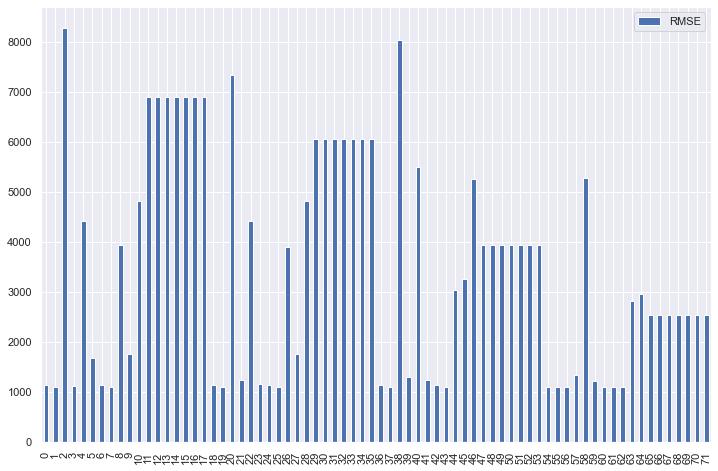

In [261]:
pred_df.plot(kind='bar', figsize=(12,8))

In [262]:
# change the problem a bit
train_df["prep_time"] = train_df["actual_total_delivery_duration"] - train_df["estimated_store_to_consumer_driving_duration"] - train_df["estimated_order_place_duration"]

# not scaling affects the performance, so continue to scale but it doesn't matter much which scaler we used
scalers = {
    "Standard scaler": StandardScaler(),
}

feature_sets = {
    "selected_features_40": importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
}

for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():  
            #drop estimated_store_to_consumer_driving_duration and estimated_order_place_duration
            X = train_df[feature_set].drop(columns=["estimated_store_to_consumer_driving_duration", 
                                           "estimated_order_place_duration"])
            y = train_df["prep_time"]
            
            # to get indices
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            train_indices = X_train.index
            test_indices  = X_test.index
            
            # scale
            X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
            
            # apply indexing
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
            _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=False)
            rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)

-----scaled with Standard scaler-------- included columns are selected_features_40



KeyError: "['estimated_order_place_duration'] not found in axis"

In [ ]:
# not scaling affects the performance, so continue to scale but it doesn't matter much which scaler we used
scalers = {
    "Standard scaler": StandardScaler(),
}

feature_sets = {
    "selected_features_40": importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
}

# continue with best performing model
regression_models = {
    "LGBM": LGBMRegressor(),
}

for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():  
            #drop estimated_store_to_consumer_driving_duration and estimated_order_place_duration
            X = train_df[feature_set].drop(columns=["estimated_store_to_consumer_driving_duration", 
                                           "estimated_order_place_duration"])
            y = train_df["prep_time"]
            
            # to get indices
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            train_indices = X_train.index
            test_indices  = X_test.index
            
            # scale
            X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
            
            # apply indexing
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
            _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=False)
            rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)

In [ ]:
# choose best perform model and extract the predictions for preparation duration
pred_values_dict = {
    "actual_total_delivery_duration": train_df["actual_total_delivery_duration"][test_indices].values.tolist(), 
    "prep_duration_prediction":y_predict[:,0].tolist(),
    "estimated_store_to_consumer_driving_duration": train_df["estimated_store_to_consumer_driving_duration"][test_indices].values.tolist(),
    "estimated_order_place_duration": train_df["estimated_order_place_duration"][test_indices].values.tolist(),             
}

In [ ]:
# convert it to dataframe from dict
values_df = pd.DataFrame.from_dict(pred_values_dict)
values_df

In [ ]:
# sum predictions up with non preparation activities such as order placing and driving.
values_df["sum_total_delivery_duration"] = values_df["prep_duration_prediction"] + values_df["estimated_store_to_consumer_driving_duration"] + values_df["estimated_order_place_duration"]
values_df

In [ ]:
# check new error rate
mean_squared_error(values_df["actual_total_delivery_duration"], values_df["sum_total_delivery_duration"], squared=False)

In [ ]:
# What if we use another regression to obtain the actual total delivery duration?
X = values_df[["prep_duration_prediction", "estimated_store_to_consumer_driving_duration", "estimated_order_place_duration"]]
y = values_df["actual_total_delivery_duration"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
regression_models = {
    "LinearReg" : linear_model.LinearRegression(),
    "Ridge" : linear_model.Ridge(),
    "DecisionTree" : tree.DecisionTreeRegressor(max_depth=6),
    "RandomForest" : RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "LGBM": LGBMRegressor(),
    "MLP":  MLPRegressor(),
}
for model_name in regression_models.keys():
    _, y_predict, _, _= make_regression(
        X_train, y_train, X_test, y_test,regression_models[model_name], model_name, verbose=False)
    print("RMSE of:",model_name, mean_squared_error(y_test,y_predict, squared=False))

### Deep Learning

In [ ]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
tf.random.set_seed(42)

# Neural network
def create_model(feature_set_size):
    
    # define the model
    model = Sequential()
    model.add(Dense(16, input_dim=feature_set_size, activation='relu'))
    model.add(Dense(1, activation='linear'))
    
    # compile the model
    model.compile(optimizer='sgd', loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    return model

In [ ]:
print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
print("")
model_name = "ANN"   
scaler_name = "Standard scaler"
X = values_df[["prep_duration_prediction", "estimated_store_to_consumer_driving_duration", "estimated_order_place_duration"]]
y = values_df["actual_total_delivery_duration"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
print("feature_set_size:",X_train_scaled.shape[1])
model = create_model(feature_set_size=X_train_scaled.shape[1])
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=64, verbose=1)
y_pred = model.predict(X_test_scaled)
rmse_error = rmse_with_inv_transform(y_scaler, y_test, y_pred, model_name)
pred_dict["regression_model"].append(model_name)
pred_dict["feature_set"].append(feature_set_name)
pred_dict["scaler_name"].append(scaler_name)
pred_dict["RMSE"].append(rmse_error)

In [ ]:
plt.plot(history.history['loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.show()